In [81]:
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.special import softmax
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize

from datasets import Dataset
import evaluate

from transformers import (
    DataCollatorForTokenClassification,
    DistilBertForTokenClassification,
    DistilBertTokenizerFast,
    Trainer,
    TrainingArguments,
)


In [82]:
# 1: Load data and Patch IOB CSV to tag any “drug” tokens as B-DRUG

def patch_ner_csv(input_csv: str, output_csv: str):
    df = pd.read_csv(input_csv)
    # any “O” word containing “drug” → B-DRUG
    mask = (
        (df["tag"] == "O")
        & df["word"].str.contains(r"drug", flags=re.IGNORECASE, regex=True)
    )
    df.loc[mask, "tag"] = "B-DRUG"
    df.to_csv(output_csv, index=False)
    print("Wrote patched file:", output_csv)
    print("Tags now:", sorted(df["tag"].unique()))

raw_csv     = "../data/ner_data.csv"
patched_csv = "../data/ner_data_with_drug.csv"
patch_ner_csv(raw_csv, patched_csv)


Wrote patched file: ../data/ner_data_with_drug.csv
Tags now: ['B-DOSAGE', 'B-DRUG', 'B-SYMPTOM', 'O']


In [83]:
# 2: Load the patched CSV, group into sentences, and create an HF Dataset

# 1) Read your patched file
df = pd.read_csv("../data/ner_data_with_drug.csv")

# 2) Group into sentences
sentences = df.groupby("sentence_id")["word"].apply(list).tolist()
tags      = df.groupby("sentence_id")["tag"].apply(list).tolist()

# 3) Build label maps
label_list = ["O", "B-DRUG", "B-DOSAGE", "B-SYMPTOM"]
label2id   = {lbl: idx for idx, lbl in enumerate(label_list)}
id2label   = {idx: lbl for lbl, idx in label2id.items()}

# 4) Create an HF Dataset and split
dataset = Dataset.from_dict({
    "tokens":   sentences,
    "ner_tags": [[label2id[t] for t in tag_seq] for tag_seq in tags],
})
dataset = dataset.train_test_split(test_size=0.2)

print(dataset)


DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 800
    })
    test: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 200
    })
})


In [84]:
# 3: Tokenize the dataset and align labels with subwords

# 1. load tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

# 3. tokenize + align
def tokenize_and_align_labels(examples):
    # tokenize the words (we pass list of tokens)
    tokenized = tokenizer(
        examples["tokens"],
        is_split_into_words=True,
        truncation=True,
        padding="max_length",
    )
    all_labels = examples["ner_tags"]
    aligned_labels = []

    for i, labels in enumerate(all_labels):
        word_ids = tokenized.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                # special tokens
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                # first subword of a word
                label_ids.append(labels[word_idx])
            else:
                # subsequent subword → ignore
                label_ids.append(-100)
            previous_word_idx = word_idx
        aligned_labels.append(label_ids)

    tokenized["labels"] = aligned_labels
    return tokenized

# Quick sanity check (do not map yet):
sample = dataset["train"][0]
print(sample["tokens"])
print(sample["ner_tags"])
print(tokenize_and_align_labels({"tokens":[sample["tokens"]], "ner_tags":[sample["ner_tags"]]})["labels"][0][:20])


['Patients', 'experienced', 'rash', 'after', 'administration', 'of', '75mg', 'of', 'DrugC']
[0, 0, 3, 0, 0, 0, 2, 0, 1]
[-100, 0, 0, 3, 0, 0, 0, 2, -100, 0, 1, -100, -100, -100, -100, -100, -100, -100, -100, -100]


In [85]:
# 4. Tokenize & align labels for the entire dataset

tokenized_datasets = dataset.map(
    tokenize_and_align_labels,      # your alignment fn
    batched=True,                   # process in batches
    remove_columns=["tokens", "ner_tags"]  # drop the raw word/tag columns
)

# 6. Inspect the result
print(tokenized_datasets)                   # see train/test sizes & new features
print(tokenized_datasets["train"][0])       # view input_ids, attention_mask, labels for first example
print(tokenized_datasets["train"].column_names)  # confirm labels column exists


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 800
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 200
    })
})
{'input_ids': [101, 5022, 5281, 23438, 2044, 3447, 1997, 4293, 24798, 1997, 4319, 2278, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [86]:
# 5. Load a DistilBERT token-classification model

model = DistilBertForTokenClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=len(label_list),   # 4 in your case: O, B-DRUG, B-DOSAGE, B-SYMPTOM
    id2label=id2label,
    label2id=label2id,
)

# Sanity-check
print(model.config)  # should show num_labels=4, plus your id2label/label2id mappings


Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "O",
    "1": "B-DRUG",
    "2": "B-DOSAGE",
    "3": "B-SYMPTOM"
  },
  "initializer_range": 0.02,
  "label2id": {
    "B-DOSAGE": 2,
    "B-DRUG": 1,
    "B-SYMPTOM": 3,
    "O": 0
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.52.4",
  "vocab_size": 30522
}



In [87]:
# 6. Prepare data collator, metric, and compute_metrics fn

# data collator will pad your inputs & labels to max length
data_collator = DataCollatorForTokenClassification(tokenizer)

# load seqeval for entity-level metrics
seqeval = evaluate.load("seqeval")

def compute_metrics(p):
    preds, labels = p.predictions, p.label_ids
    # move from logits to label indices
    preds = np.argmax(preds, axis=-1)

    # convert to label strings
    true_labels = [
        [id2label[label_id] for label_id in seq if label_id != -100]
        for seq in labels
    ]
    true_preds = [
        [id2label[pred_id] for (pred_id, label_id) in zip(seq_pred, seq_label) if label_id != -100]
        for seq_pred, seq_label in zip(preds, labels)
    ]

    results = seqeval.compute(predictions=true_preds, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall":    results["overall_recall"],
        "f1":        results["overall_f1"],
        "accuracy":  results["overall_accuracy"],
    }

In [88]:
# 7. Training Arguments

training_args = TrainingArguments(
    # I/O
    output_dir="../results",            # where to save checkpoints & final model
    logging_dir="../logs",              # TensorBoard logs

    # Evaluation
    eval_strategy="steps",              # run evaluation by steps
    eval_steps=1,                       #   → every single training step
    eval_delay=0,                       #   → no warm‐up delay before first eval

    # Logging
    logging_strategy="steps",           # log training metrics by steps
    logging_steps=1,                    #   → every single training step

    # Checkpointing
    save_strategy="no",                 # disable auto‐saving
    load_best_model_at_end=False,       # (irrelevant when save_strategy="no")

    # Optimization
    learning_rate=2e-5,
    weight_decay=0.01,

    # Data
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,

    # Training length
    num_train_epochs=1,
)

In [89]:
# 8 Instantiate Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset= tokenized_datasets["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

print("Trainer ready:", trainer)

/var/folders/h0/hyrmq_xj0nz_7j032crdtlrh0000gn/T/ipykernel_96229/3162398595.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Trainer ready: <transformers.trainer.Trainer object at 0x33171b6a0>


In [ ]:
# 9 Start fine-tuning
train_result = trainer.train()


/Users/jmsung/miniconda3/envs/bio-ml/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,1.329600,1.157489,0.709220,0.333333,0.453515,0.712836
2,1.152600,1.023368,1.000000,0.308333,0.471338,0.752239
3,1.036800,0.908105,1.000000,0.130000,0.230088,0.688358
4,0.949200,0.812201,1.000000,0.041667,0.080000,0.656716
5,0.832100,0.734526,1.000000,0.021667,0.042414,0.649552
6,0.768300,0.668806,1.000000,0.023333,0.045603,0.650149
7,0.699400,0.607341,1.000000,0.063333,0.119122,0.664478
8,0.633600,0.547424,1.000000,0.231667,0.376184,0.724776
9,0.562300,0.489294,1.000000,0.418333,0.589894,0.791642
10,0.531400,0.434158,1.000000,0.630000,0.773006,0.867463


/Users/jmsung/miniconda3/envs/bio-ml/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# 10. Evaluate & print metrics
metrics = trainer.evaluate()
print(metrics)

/Users/jmsung/miniconda3/envs/bio-ml/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.014522211626172066, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_accuracy': 1.0, 'eval_runtime': 7.6285, 'eval_samples_per_second': 26.218, 'eval_steps_per_second': 1.704, 'epoch': 1.0}


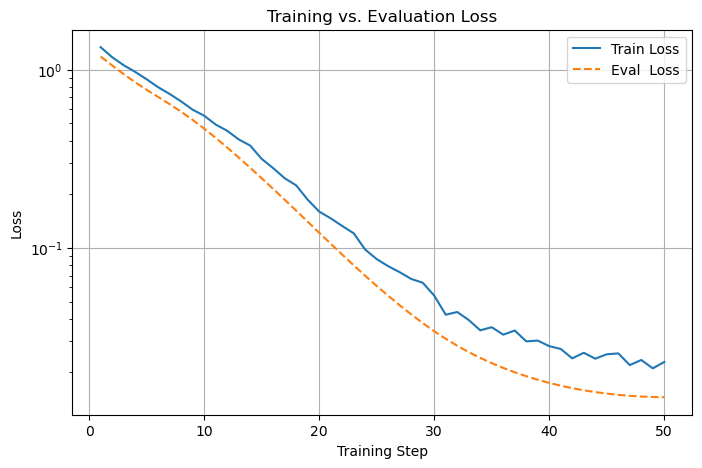

In [ ]:
# 11. Plotting Training and Evaluation Loss

# 1) Pull out the log history
hist = pd.DataFrame(trainer.state.log_history)

# 2) Separate train-loss and eval-loss entries
train_df = hist[hist['loss'].notnull()]
eval_df  = hist[hist['eval_loss'].notnull()]

# 3) One figure, two curves
plt.figure(figsize=(8,5))
plt.plot(train_df['step'], train_df['loss'],     label='Train Loss')
plt.plot(eval_df ['step'], eval_df ['eval_loss'], label='Eval  Loss', linestyle='--')
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.title('Training vs. Evaluation Loss')
plt.legend()
plt.grid(True)
plt.yscale('log')

plt.savefig("../results/figs/training_vs_eval_loss.png", dpi=300, bbox_inches="tight")
plt.show()


In [ ]:
# 12. Run predictions and print a classification report

# 1. Run predictions
predictions, labels, _ = trainer.predict(tokenized_datasets["test"])
pred_ids = np.argmax(predictions, axis=2)

# 2. Flatten out the -100s (which we used to mask sub-tokens & specials)
true_labels = []
pred_labels = []
for lab_seq, pred_seq in zip(labels, pred_ids):
    for lab, pred in zip(lab_seq, pred_seq):
        if lab != -100:
            true_labels.append(id2label[lab])
            pred_labels.append(id2label[pred])

# 3. Print a sklearn‐style report
print(classification_report(
    true_labels,
    pred_labels,
    labels=["O","B-DRUG","B-DOSAGE","B-SYMPTOM"],
    zero_division=0
))


              precision    recall  f1-score   support

           O       1.00      1.00      1.00      1075
      B-DRUG       1.00      1.00      1.00       200
    B-DOSAGE       1.00      1.00      1.00       200
   B-SYMPTOM       1.00      1.00      1.00       200

    accuracy                           1.00      1675
   macro avg       1.00      1.00      1.00      1675
weighted avg       1.00      1.00      1.00      1675



/Users/jmsung/miniconda3/envs/bio-ml/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


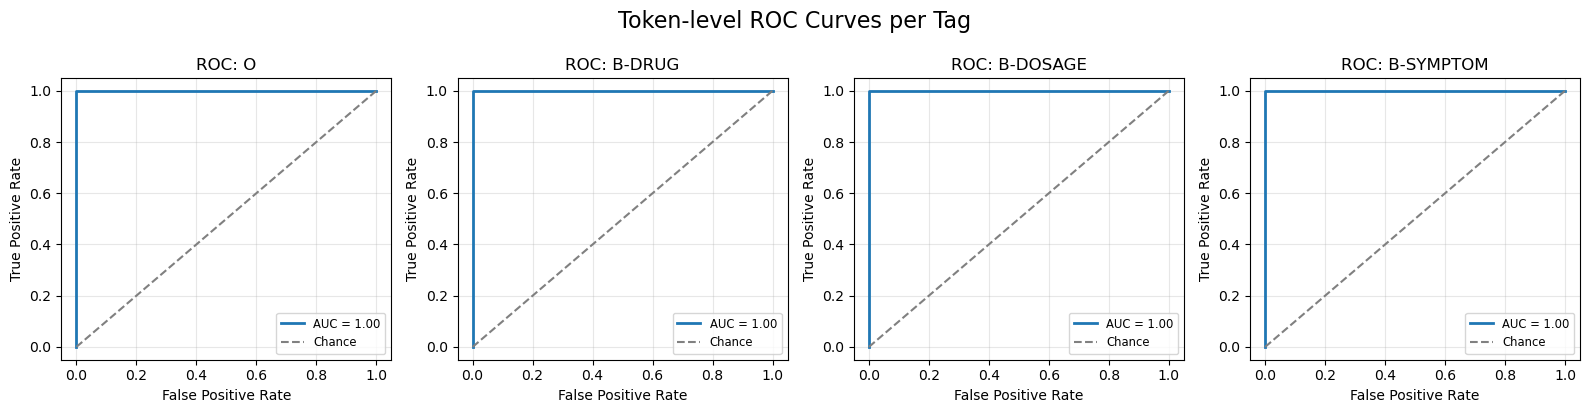

In [ ]:
# 13. Plot token‐level ROC curves for each label

# --- 1) Run predictions on your test set ---
predictions, label_ids, _ = trainer.predict(tokenized_datasets["test"])
# predictions.shape = (n_examples, seq_len, n_labels)
# label_ids.shape    = (n_examples, seq_len)

# --- 2) Softmax → token‐level probabilities ---
probs = softmax(predictions, axis=-1)   # same shape as predictions

# --- 3) Flatten out sequence dimension, drop all masked tokens (label == -100) ---
flat_true = []
flat_probs = []  # list of [n_labels] prob vectors

for labs, ps in zip(label_ids, probs):
    # labs: (seq_len,), ps: (seq_len, n_labels)
    mask = labs != -100
    flat_true.extend(labs[mask])
    flat_probs.append(ps[mask])

# now turn flat_probs into a 2D array (n_tokens, n_labels)
flat_probs = np.concatenate(flat_probs, axis=0)
y_true     = np.array(flat_true)              # shape (n_tokens,)
n_labels   = flat_probs.shape[1]

# --- 4) Binarize the true labels for OvR ROC ---
y_bin = label_binarize(y_true, classes=list(range(n_labels)))

# --- 5) Plot each label’s ROC curve ---
fig, axes = plt.subplots(1, n_labels, figsize=(4*n_labels, 4), squeeze=False)
axes = axes.flatten()

for i, ax in enumerate(axes):
    fpr, tpr, _ = roc_curve(y_bin[:, i], flat_probs[:, i])
    roc_auc     = auc(fpr, tpr)

    ax.plot(fpr, tpr, lw=2, label=f"AUC = {roc_auc:.2f}")
    ax.plot([0,1], [0,1], linestyle="--", color="gray", label="Chance")
    ax.set_title(f"ROC: {id2label[i]}")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc="lower right", fontsize="small")
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.suptitle("Token‐level ROC Curves per Tag", fontsize=16, y=1.02)
plt.subplots_adjust(top=0.85)
plt.savefig("../results/figs/roc_curves.png", dpi=300, bbox_inches="tight")
plt.show()